# How to use FasterAI

In [1]:
!pip install git+https://github.com/nathanhubens/fasterai.git
!pip install git+https://github.com/nathanhubens/CUTE22.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/nathanhubens/fasterai.git to /tmp/pip-req-build-6z2z4eyz
  Running command git clone -q https://github.com/nathanhubens/fasterai.git /tmp/pip-req-build-6z2z4eyz
  Created wheel for fasterai: filename=fasterai-0.1.9-py3-none-any.whl size=21311 sha256=637b7046c18447f81fd7606e430d15f19e4d2eedf367a72978aa3cd7d9508356
  Stored in directory: /tmp/pip-ephem-wheel-cache-0e4eza0v/wheels/5e/e5/6d/0752d90e4fa5c28b88bdb877fce0ddb9384d40fa5d30cc29a9
Successfully built fasterai
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/nathanhubens/CUTE22.git to /tmp/pip-req-build-217yow3e
  Running command git clone -q https://github.com/nathanhubens/CUTE22.git /tmp/pip-req-build-217yow3e
  Created wheel for cute: filename=cute-0.0.1-py3-none-any.whl size=2346 sha256=c7cbb063719e238d5561b46d64da313fc2bdff

In [2]:
from fastai.vision.all import *
from fasterai.sparse.all import *
from fasterai.distill.all import *
from cute.utils import *

In [3]:
size, bs = 64, 32
dls = get_dls(size, bs)

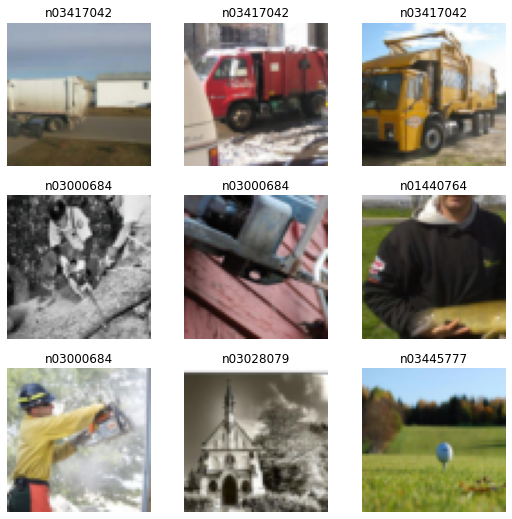

In [4]:
dls.show_batch()

Let's start with a bit of context for the purpose of the demonstration. Imagine that we want to deploy a **VGG11** model on a mobile device that has limited storage capacity and that our task requires our model to run sufficiently fast. It is known that parameters and speed efficiency are not the strong points of **VGG11** but let's see what we can do with it.

Let's first check the number of parameters and the inference time of **VGG11**.

In [5]:
learn = Learner(dls, models.vgg11_bn(num_classes=10), metrics=[accuracy])

So, **VGG11** has **128** millions of parameters

In [6]:
count_parameters(learn.model)

Total parameters : 128,812,810


And takes around **3.5ms** to perform inference on a single image.

And takes around **9.5ms** to perform inference on a single batch.

In [7]:
model = learn.model.eval().cuda()
x,y = dls.one_batch()

In [8]:
%%timeit -n 100
model(x[0][None].cuda())

100 loops, best of 5: 10.6 ms per loop


We will first train our **VGG11** model to have a **baseline** of what performance we should expect from it.

In [9]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.947598,1.671272,0.447134,00:57
1,1.483474,1.438154,0.536561,00:56
2,1.205271,1.069178,0.652484,00:55
3,0.994274,0.923337,0.695796,00:55
4,0.950883,0.873275,0.716943,00:55


So we would like our network to have comparable accuracy but fewer parameters and running faster... And the first technique that we will show how to use is called **Knowledge Distillation**

---

## **Knowledge Distillation**

In [10]:
from fasterai.distill.all import *

The first thing to do is to find a teacher, which can be any model, that preferrably performs well. We will chose **VGG19** for our demonstration. To make sure it performs better than our **VGG11** model, let's start from a pretrained version.

In [11]:
teacher = Learner(dls, models.vgg19_bn(pretrained=True), metrics=[accuracy])
teacher.model.classifier[6] = nn.Linear(4096, 10)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [12]:
teacher.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.565604,0.450512,0.863440,01:00
1,0.348647,0.274276,0.911592,01:00
2,0.250260,0.258355,0.918726,01:00


Our teacher has over **90%** of accuracy which is pretty good, it is ready to take a student under its wing. So let's create our student model and train it with the **Knowledge Distillation** callback:

In [13]:
kd = KnowledgeDistillationCallback(teacher.model, SoftTarget, weight=0.5)

If you want to use KD on the features, remember to use the `get_model_layers` function to get the layer names of your student/teacher.

In [14]:
student = Learner(dls, models.vgg11_bn(num_classes=10), metrics=[accuracy])
student.fit_one_cycle(5, 1e-4, cbs=kd)

epoch,train_loss,valid_loss,accuracy,time
0,7.875354,6.565719,0.436433,01:09
1,5.077483,4.568491,0.586242,01:17
2,4.257666,3.702543,0.650701,01:09
3,3.581180,2.843118,0.719236,01:09
4,3.302445,2.683189,0.727643,01:09


In [15]:
# Saving Checkpoint
torch.save(student.model.state_dict(), 'weight_kd.pth')

And we can see that indeed, the knowledge of the teacher was useful for the student, as it is clearly overperforming the vanilla **VGG11**.

---

<br>

## **Sparsifying**

In [17]:
#hide
from fasterai.sparse.all import *

In [25]:
# Optional: if you want to start the experiment again with previous weights
student.model.load_state_dict(torch.load('weight_kd.pth'))

<All keys matched successfully>

In [20]:
sp_cb = SparsifyCallback(sparsity=20, granularity='filter', context='local', criteria=large_final, schedule=cos)

In [21]:
student.fit(5, 1e-5, cbs=sp_cb)

Pruning of filter until a sparsity of [20]%
Saving Weights at epoch 0


epoch,train_loss,valid_loss,accuracy,time
0,0.885033,0.874142,0.710828,00:56
1,0.931558,0.877461,0.719745,00:56
2,0.981665,0.893665,0.714650,00:56
3,0.992095,0.890901,0.708535,00:56
4,0.940297,0.890699,0.708535,00:56


Sparsity at the end of epoch 0: [1.91]%
Sparsity at the end of epoch 1: [6.91]%
Sparsity at the end of epoch 2: [13.09]%
Sparsity at the end of epoch 3: [18.09]%
Sparsity at the end of epoch 4: [20.0]%
Final Sparsity: [20.0]%
Sparsity in Conv2d 2: 20.31%
Sparsity in Conv2d 6: 20.31%
Sparsity in Conv2d 10: 19.92%
Sparsity in Conv2d 13: 19.92%
Sparsity in Conv2d 17: 20.12%
Sparsity in Conv2d 20: 20.12%
Sparsity in Conv2d 24: 20.12%
Sparsity in Conv2d 27: 20.12%


In [22]:
# Saving Checkpoint
torch.save(student.model.state_dict(), 'weight_sp.pth')

<br>

Let's now see how much we gained in terms of speed. Because we removed **40%** of convolution filters, we should expect crazy speed-up right ? 

In [37]:
model = student.model.eval()

In [38]:
%%timeit -n 100
model(x[0][None].cuda())

100 loops, best of 5: 11.1 ms per loop


Well actually, no. We didn't remove any parameters, we just replaced some by zeroes, remember? The amount of parameters is still the same:

In [29]:
count_parameters(model)

Total parameters : 128,812,810


Which leads us to the next section.

---

## **Pruning**

Why don't we see any acceleration even though we removed half of the parameters? That's because natively, our **GPU** does not know that our matrices are sparse and thus isn't able to accelerate the computation. The easiest work around, is to **physically** remove the parameters we zeroed-out. But this operation requires to change the architecture of the network. 

> Note: This operation should be lossless as it only removes filters that already do not participate in the network anymore.

So in the case of our example, it gives: 

In [30]:
from fasterai.sparse.pruner import Pruner

In [31]:
pruner = Pruner()
pruned_model = pruner.prune_model(student.model)

Let's now see what our model is capable of now:

In [32]:
count_parameters(pruned_model)

Total parameters : 104,806,713


And in terms of speed:

In [34]:
%%timeit
pruned_model(x[0][None].cuda())

100 loops, best of 5: 3.59 ms per loop


<br>

Yay ! Now we can talk ! Let's just double check that our accuracy is unchanged and that we didn't mess up somewhere:

In [39]:
pruned_learner = Learner(dls, pruned_model, metrics=[accuracy])
pruned_learner.validate()

(#2) [0.8906990885734558,0.7085350155830383]

<br>

In [40]:
# Saving Checkpoint
torch.save(pruned_learner.model.state_dict(), 'weight_pruned.pth')

And there is actually more that we can do ! Let's keep going ! 

---

## **Batch Normalization Folding**

> Note: This operation should also be lossless as it redefines the convolution to take batch norm into account and is thus equivalent.

In [41]:
from fasterai.misc.bn_folding import *

Let's do this with our model ! 

In [42]:
bn_folder = BN_Folder()

In [43]:
folded_model = bn_folder.fold(pruned_learner.model)

The parameters drop is generally not that significant, especially in a network such as **VGG** where almost all parameters are contained in the FC layers but, hey, any gain is good to take.

In [44]:
count_parameters(folded_model)

Total parameters : 104,802,315


Now that we removed the batch normalization layers, we should again see a speedup.

In [45]:
%%timeit -n 100
folded_model(x[0][None].cuda())

100 loops, best of 5: 2.7 ms per loop


Again, let's double check that we didn't mess up somewhere:

In [46]:
folded_learner = Learner(dls, folded_model, metrics=[accuracy])
folded_learner.validate()

(#2) [0.8906992673873901,0.7085350155830383]

In [47]:
# Saving Checkpoint
torch.save(folded_learner.model.state_dict(), 'weight_bn.pth')

---

## **FC Layers Factorization**

> Note: This time, the decomposition is not exact, so we expect a drop in performance afterwards and further retraining will be needed.

Which gives with our example, if we only want to keep half of them:

In [48]:
from fasterai.misc.fc_decomposer import *

In [57]:
# Optional: if you want to start the experiment again with previous weights
folded_learner.model.load_state_dict(torch.load('weight_bn.pth'))

<All keys matched successfully>

In [59]:
fc_decomposer = FC_Decomposer()
decomposed_model = fc_decomposer.decompose(folded_learner.model, percent_removed=0.5)

How many parameters do we have now ?

In [60]:
count_parameters(decomposed_model)

Total parameters : 72,126,525


And how much time did we gain ? 

In [61]:
decomposed_model = decomposed_model.eval()

In [62]:
%%timeit -n 100
decomposed_model(x[0][None].cuda())

100 loops, best of 5: 2.8 ms per loop


<br>

In [63]:
# Saving Checkpoint
torch.save(decomposed_model.state_dict(), 'weight_dec.pth')

In [64]:
final_learner = Learner(dls, decomposed_model, metrics=[accuracy])

In [65]:
final_learner.validate()

(#2) [1.3527679443359375,0.4881528615951538]

However, this technique is an approximation so it is not lossless, so we should retrain our network a bit to recover its performance.

In [66]:
# Optional: if you want to start the experiment again with previous weights
final_learner.model.load_state_dict(torch.load('weight_dec.pth'))

<All keys matched successfully>

In [67]:
final_learner.fit_one_cycle(3, 1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,1.168621,1.105153,0.627006,00:53
1,1.072543,1.044195,0.671847,00:54
2,0.980752,1.019951,0.674650,00:52


This operation is usually less useful for more recent architectures as they usually do not have that many parameters in their fully-connected layers.

---